<a href="https://colab.research.google.com/github/nishant152030/Grover-Algorithm-for-Bi-prime/blob/main/GroverAlgorithm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Grover's Algorithm**

Grover's algorithm is one of the most famous quantum algorithms introduced by Lov Grover in 1996 . It has initially been proposed for unstructured search problems, i.e. for finding a marked element in a unstructured database. However, Grover's algorithm is now a subroutine to several other algorithms, such as Grover Adaptive Search.

# Import Libraries:
 Necessary libraries are imported for quantum computing (PennyLane), numerical operations (NumPy), and plotting (Matplotlib).

In [2]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 35.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

# Function Definitions:

***add_k_fourier:*** Applies a controlled phase rotation for the k-th Fourier basis.

---


***multiplication:*** Simulates multiplication on quantum registers by applying the Quantum Fourier Transform, controlled phase rotations, and its inverse.

In [4]:
def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])


def multiplication(reg_x, reg_y, reg_z):
    # prepare sol-qubits to counting
    qml.QFT(wires=reg_z)

    # add m to the counter
    for i in range(len(reg_y)):
        for j in range(len(reg_x)):
            coeff = 2 ** (len(reg_x) + len(reg_y) - i - j - 2)
            qml.ctrl(add_k_fourier, control=[reg_y[i], reg_x[j]])(coeff, reg_z)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=reg_z)

Number and qubits needed

In [26]:
N=35
n=np.ceil(np.log2(N))
n=int(n)

# Qubit Allocation:

reg_z: Qubits for the solution register.


---


reg_x: Qubits for the factor p.


---


reg_y: Qubits for the factor q.

In [27]:
reg_z = [i for i in range(n)]   # qubits needed to encode the solution
reg_x = [i for i in range(n, 2*n-2)]                 # qubits needed to encode factor p
reg_y = [i for i in range(2*n-2, 3*n-3)]                 # qubits needed to encode factor q

# Quantum Device Initialization:
 The PennyLane quantum device is initialized with the defined qubits. Also, number of iterations for Grover's algorithm is calculated.

In [28]:
dev = qml.device("default.qubit", wires=reg_x + reg_y + reg_z)

n_wires = len(dev.wires)

#Create variable for number of iterations
number_of_iterations = int((np.pi/4)*np.sqrt(N)) - 1

# QNode Definition:

***factorization:*** A QNode that sets up the factorization circuit using the registers and performs Grover's search to find the factors of N.

In [29]:
dev = qml.device("default.qubit", wires=reg_x + reg_y + reg_z)

n_wires = len(dev.wires)

#Create variable for number of iterations
number_of_iterations = int((np.pi/4)*np.sqrt(N)) - 1

@qml.qnode(dev)
def factorization(N, reg_x, reg_y, reg_z, number_of_iterations):
    # Superposition of the input
    for wire in reg_x:
        qml.Hadamard(wires=wire)

    for wire in reg_y:
        qml.Hadamard(wires=wire)

    for i in range(number_of_iterations):
    # Apply the multiplication
      multiplication(reg_x, reg_y, reg_z)

    # Change sign of N
      qml.FlipSign(N, wires=reg_z)

    # Uncompute multiplication
      qml.adjoint(multiplication)(reg_x, reg_y, reg_z)

    # Apply Grover operator
      qml.GroverOperator(wires=reg_x + reg_y)

    return qml.probs(wires=reg_x)

# Finding Factors:

The factors p and q are found by measuring the maximum probability states of the registers reg_x and reg_y.
A check is performed to ensure valid factor pairs.

In [30]:
p = np.argmax(factorization(N, reg_x, reg_y, reg_z, number_of_iterations))
q = np.argmax(factorization(N, reg_y, reg_x, reg_z, number_of_iterations))

#This bit of code is added to avoid the errors when the size of register is large
if p>=q:
  p = N//q
else:
  q = N//p

print(p)
print(q)

5
7


# Output:

The factors of N are printed.
The quantum circuit is displayed using Matplotlib.

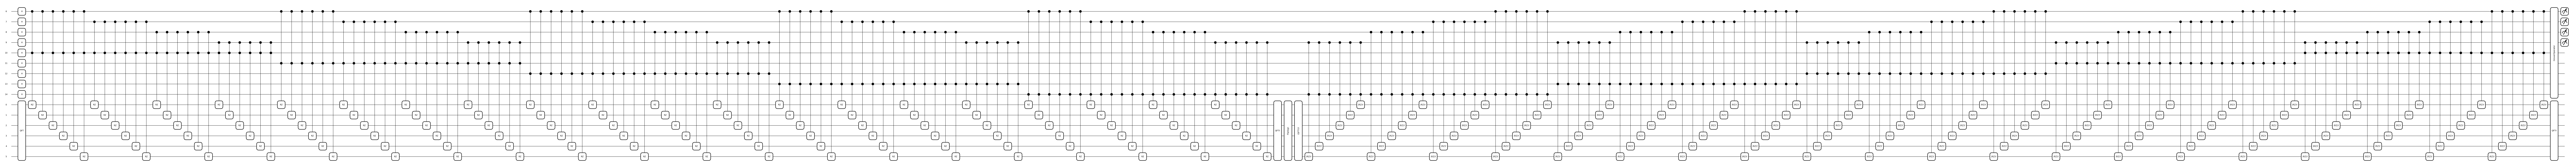

In [10]:
#Code for displaying circuit

qml.draw_mpl(factorization, show_all_wires=True)(N, reg_x, reg_y, reg_z, 1)
plt.show()